In [60]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [61]:
elevation = Image.open('Elevation/Elevation_Risk_final.tif')
cholerarisk = Image.open('Cholera/Jun_avg_Cholera_Risk_final.tif')
population = Image.open('Population/population_risk_2020_final.tif')
rainfall = Image.open('Rainfall/Rain_Anomaly_Risk_Jun_2021_final.tif')
temperature = Image.open('Temperature/Temperature_Risk_Jun_2021_final.tif')
future_chol = Image.open('Cholera/Model BD_Cholera_Risk_Jul_2021.tif')


In [65]:
print(np.nanmax(e))

4.0


In [69]:
e = np.array(elevation,dtype=np.float32)
e[e==255]=np.nan
e = e/np.nanmax(e)

c = np.array(cholerarisk,dtype=np.float32)
c[c==255]=np.nan
c = (c/(np.nanmax(c))*4)
c = c[:-1,:-1]

p = np.array(population,dtype=np.float32)
p[p==255]=np.nan
p = p[:-1,:-1]
p = p/np.nanmax(p)

r = np.array(rainfall,dtype=np.float32)
r[r==255]=np.nan
r = r[:-1,:-1]
r = r/np.nanmax(r)

t = np.array(temperature,dtype=np.float32)
t[t==255]=np.nan
t = t[:-1,:-1]
t = t/np.nanmax(t)

fu_chol = np.array(future_chol,dtype=np.float32)
fu_chol[fu_chol<-1000]=np.nan
fu_chol = fu_chol/np.nanmax(fu_chol)

In [83]:
print('{}\n{}\n{}\n{}\n{}'.format(e.shape,c.shape,p.shape,r.shape,t.shape))

(707, 559)
(707, 559)
(707, 559)
(707, 559)
(707, 559)


In [12]:
cholera_np.shape

(707, 559)

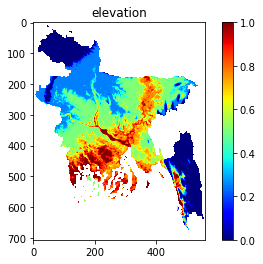

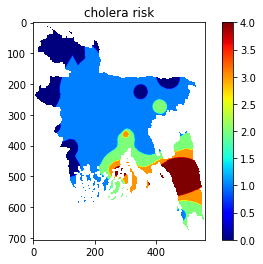

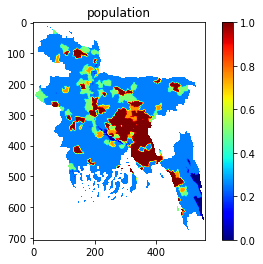

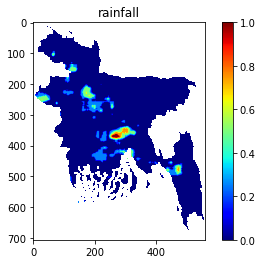

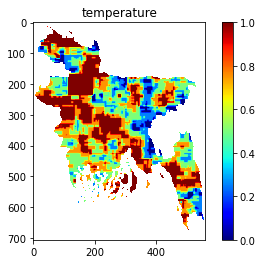

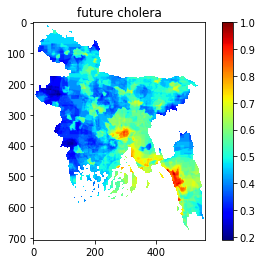

In [70]:
thelist = [e,c,p,r,t,fu_chol]
count = 0
titlelist = ['elevation','cholera risk','population','rainfall','temperature','future cholera']
for i in thelist:
    plt.figure()
    plt.title(titlelist[count])
    plt.imshow(i,cmap='jet')
    plt.colorbar()
    count+=1

In [71]:
etorch = torch.from_numpy(e).unsqueeze(0).unsqueeze(0).reshape(-1,1,1,1)
ctorch = torch.from_numpy(c).unsqueeze(0).unsqueeze(0).reshape(-1,1,1,1)
ptorch = torch.from_numpy(p).unsqueeze(0).unsqueeze(0).reshape(-1,1,1,1)
rtorch = torch.from_numpy(r).unsqueeze(0).unsqueeze(0).reshape(-1,1,1,1)
ttorch = torch.from_numpy(t).unsqueeze(0).unsqueeze(0).reshape(-1,1,1,1)

In [72]:
inp = torch.cat((etorch,ptorch,rtorch,ttorch),dim=3)
inp.shape

torch.Size([395213, 1, 1, 4])

In [73]:
f1 = [True if torch.isfinite(inp[i]).all() == True else False for i in range(inp.shape[0])]

In [74]:
inp_nonans = inp[f1]
print(inp_nonans.shape)

out_nonans = ctorch[f1]
print(out_nonans.shape)

torch.Size([175507, 1, 1, 4])
torch.Size([175507, 1, 1, 1])


In [75]:
torch.save(inp_nonans,'cholerainput_normed.pt')
torch.save(out_nonans,'choleraoutput.pt')

In [76]:
torch.cuda.empty_cache()
torch.cuda.current_device()
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
GeForce RTX 2080 Ti


In [93]:
import torch
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.io import loadmat
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from torchvision import transforms
import glob
import torchvision
from torchvision import models
from torch.utils.data import random_split
from random import choice
from scipy import signal


class dp_patches(Dataset):
    def __init__(self,x,y):
        self.x = torch.load(x)[:,:,:,2]
        print(self.x.shape)
        self.y = torch.load(y).long()
        rand_pts = torch.from_numpy(np.random.randint(0,self.x.shape[0],5000))
        self.x = self.x[rand_pts]
        self.y = self.y[rand_pts]
    def __getitem__(self,idx):
        x = self.x[idx].to('cuda')
        y = self.y[idx].to('cuda')
        return x, y
    def __len__(self):
        return self.x.shape[0]

class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.fc1 = torch.nn.Linear(1,10)
        self.fc2 = torch.nn.Linear(10,5)
        self.relu = torch.nn.ReLU(inplace=True)
        self.dropout = torch.nn.Dropout(0.85)

    def forward(self,x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
        
dset = dp_patches('cholerainput_normed.pt','choleraoutput.pt')

train_dset_size = int(0.80*len(dset))
valid_dset_size = int(0.5*(len(dset) - train_dset_size))
test_dset_size = int(0.5*(len(dset) - train_dset_size))

train_dset, valid_dset, test_dset = random_split(dset,[train_dset_size,valid_dset_size,test_dset_size])

train_dataloader = DataLoader(dataset=train_dset, batch_size=300, shuffle=True)
valid_dataloader = DataLoader(dataset=valid_dset, batch_size=300, shuffle=True)
# test_dataloader = DataLoader(dataset=test_dset,batch_size=500, shuffle=True, num_workers=0)


epochs = 1000
model = MLP()

model.cuda()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=100,verbose=False)


print('training started')
all_losses = []
all_val_losses = []
for epoch in range(epochs):
    tr_epoch_loss = 0
    val_epoch_loss = 0
    model.train()
    for x, y in train_dataloader:
        optimizer.zero_grad()
        predicted = model(x).squeeze().squeeze()
        y = y.squeeze().squeeze()
        loss = criterion(predicted,y)
        loss.backward()
        tr_epoch_loss += loss.item()
        correct = 0
        total = 0
        for xx,yy in valid_dataloader:
            pred_val = model(xx).squeeze().squeeze()
            yy = yy.squeeze().squeeze()
            _, predicted = torch.max(pred_val.data,1)
            total += yy.size(0)
            correct += (predicted == yy).sum().item()            
#             loss_val = criterion(pred_val,yy)
#             val_epoch_loss += loss_val.item()
        optimizer.step()
    print('acc of network: %d %%' % (100 * correct/total))
#     scheduler.step()
    all_losses.append(tr_epoch_loss / len(train_dataloader))
    all_val_losses.append(val_epoch_loss/len(valid_dataloader))
    if epoch % 1 == 0:
#         print('Epoch: {}   Train Loss: {}   Valid Loss: {}'.format(epoch+1, tr_epoch_loss/len(train_dataloader), val_epoch_loss/len(valid_dataloader)))
        print('Epoch: {}   Train Loss: {}'.format(epoch+1, tr_epoch_loss/len(train_dataloader)))

torch.Size([175507, 1, 1])
training started
acc of network: 47 %
Epoch: 1   Train Loss: 1.5744096721921648
acc of network: 54 %
Epoch: 2   Train Loss: 1.3879397681781225
acc of network: 54 %
Epoch: 3   Train Loss: 1.341231882572174
acc of network: 54 %
Epoch: 4   Train Loss: 1.317377405507224
acc of network: 54 %
Epoch: 5   Train Loss: 1.2882858685084753
acc of network: 54 %
Epoch: 6   Train Loss: 1.27806213923863
acc of network: 54 %
Epoch: 7   Train Loss: 1.2688640441213335
acc of network: 54 %
Epoch: 8   Train Loss: 1.2657828160694666
acc of network: 54 %
Epoch: 9   Train Loss: 1.2563560009002686
acc of network: 54 %
Epoch: 10   Train Loss: 1.2508883305958338
acc of network: 54 %
Epoch: 11   Train Loss: 1.2556754095213754
acc of network: 54 %
Epoch: 12   Train Loss: 1.2604752693857466
acc of network: 54 %
Epoch: 13   Train Loss: 1.2479243533951896
acc of network: 54 %
Epoch: 14   Train Loss: 1.2461436561175756
acc of network: 54 %
Epoch: 15   Train Loss: 1.2473521658352442
acc of ne